<a href="https://colab.research.google.com/github/VKSi/2021_01_NeuralNetworks_Intro/blob/main/HW_5_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

# Решения

## Подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/NeuralNetwork/Lesson5/'

In [ ]:
import tensorflow as tf
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.4.1
TensorFlow 2.0 Hello World


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential #, Model
from tensorflow.keras.layers import LSTM, Input, Flatten, Dense, Conv1D


# from tensorflow.keras.utils import plot_model, to_categorical

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import accuracy_score, make_scorer

### Знакомимся с датасетом

In [ ]:
data = pd.read_csv(PATH + 'airline-passengers.csv')

In [ ]:
data.shape

(144, 2)

In [ ]:
data.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


In [ ]:
data.tail(2)

,Month,Passengers
142,1960-11,390
143,1960-12,432


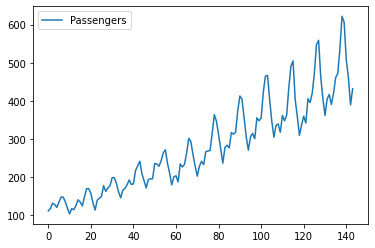

In [ ]:
data.plot()

## Подготовка данных

In [ ]:
data['YearMonth'] = data.Month

In [ ]:
data['Year'] = data.YearMonth.apply(lambda x: str(x)[:4])
data['Month'] = data.YearMonth.apply(lambda x: str(x)[5:])

In [ ]:
data.head(2)

,Month,Passengers,YearMonth,Year
0,01,112,1949-01,1949
1,02,118,1949-02,1949


In [ ]:
data = data[['Passengers', 'Year', 'Month']].rename(columns={'Passengers':'Value'})

In [ ]:
data.head(2)

,Value,Year,Month
0,112,1949,01
1,118,1949,02


In [ ]:
train_split = int(data.shape[0]/3*2)
train_split

96

In [ ]:
data_train = data[:train_split]
data_val = data[train_split:]

In [ ]:
data_train. shape

(96, 3)

In [ ]:
data_val.shape

(48, 3)

In [ ]:
scaler = StandardScaler()

In [ ]:
data_train_sc = pd.DataFrame(data=scaler.fit_transform(data_train), columns = data_train.columns, index=data_train.index)

In [ ]:
data_train_sc.head(2)

,Value,Year,Month
0,-1.421646,-1.527525,-1.593255
1,-1.337780,-1.527525,-1.303572


In [ ]:
data_val_sc = pd.DataFrame(data=scaler.transform(data_val), columns = data_val.columns, index=data_val.index)

In [ ]:
data_val_sc.head(2)

,Value,Year,Month
96,1.415822,1.963961,-1.593255
97,1.220134,1.963961,-1.303572


In [ ]:
data_sc = pd.concat([data_train_sc, data_val_sc])

In [ ]:
data_sc.shape

(144, 3)

In [ ]:
bias = 10
step = 1

In [ ]:
# длина истории для работы
p = 12

# горизонт предсказания
h = 1

X_train = data_sc[:train_split]
y_train = data_sc[(p + h) : (p + h + train_split)].Value

X_val = data_sc[(train_split + bias) : (- p - h)]
y_val = data_sc[train_split + bias + p + h:].Value

In [ ]:
X_train.shape

(96, 3)

In [ ]:
y_train.shape

(96,)

In [ ]:
X_val.shape

(25, 3)

In [ ]:
y_val.shape

(25,)

## Построение модели

In [ ]:
# параметры модели для обучения
learning_rate = 0.001
batch_size = 12
epochs = 20

In [ ]:
def model_preparation(learning_rate = 0.001, batch_size = 12, epochs = 20, p = 12):
  dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length = p,
    sampling_rate = 1,
    batch_size = batch_size,
  )
  dataset_val = timeseries_dataset_from_array(
      X_val,
      y_val,
      sequence_length = p,
      sampling_rate = 1,
      batch_size = batch_size,
  )
  for batch in dataset_train.take(2):
    inputs, targets = batch

  print("Input shape:", inputs.numpy().shape)
  print("Target shape:", targets.numpy().shape)

  return dataset_train, dataset_val, inputs, targets

In [ ]:
dataset_train, dataset_val, inputs, targets = model_preparation(learning_rate = 0.001, batch_size = 12, epochs = 20)

In [ ]:
def my_model():
  model = Sequential()

  model.add(LSTM(24, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
  model.add(LSTM(24, return_sequences="True"))
  model.add(Conv1D(48, 3, activation="linear"))
  model.add(Flatten())
  model.add(Dense(3, activation="linear"))
  model.add(Dense(1, activation="linear"))

  model.compile(loss="mse", optimizer="adam", metrics=['mae'])

  return model

In [ ]:
callback = EarlyStopping(monitor='val_mae', patience=5)
model = my_model()

Epoch 1/20
8/8 [==============================] - 4s 135ms/step - loss: 0.5420 - mae: 0.6124 - val_loss: 5.0658 - val_mae: 2.0690
Epoch 2/20
8/8 [==============================] - 0s 24ms/step - loss: 0.1441 - mae: 0.2860 - val_loss: 1.4708 - val_mae: 0.9111
Epoch 3/20
8/8 [==============================] - 0s 24ms/step - loss: 0.1954 - mae: 0.3848 - val_loss: 1.1295 - val_mae: 0.7802
Epoch 4/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0881 - mae: 0.2246 - val_loss: 1.5538 - val_mae: 0.9815
Epoch 5/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0917 - mae: 0.2349 - val_loss: 1.0159 - val_mae: 0.7534
Epoch 6/20
8/8 [==============================] - 0s 24ms/step - loss: 0.0776 - mae: 0.2122 - val_loss: 0.6860 - val_mae: 0.6009
Epoch 7/20
8/8 [==============================] - 0s 28ms/step - loss: 0.0633 - mae: 0.1977 - val_loss: 0.7576 - val_mae: 0.6558
Epoch 8/20
8/8 [==============================] - 0s 26ms/step - loss: 0.0589 - mae: 0.1915 - va

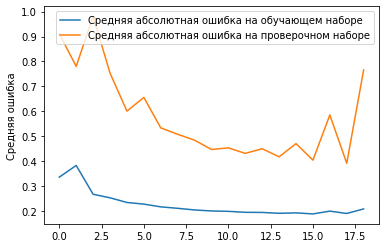

In [ ]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Видно, что после 15-й эпохи начинается преобучение

In [ ]:
model = my_model()

In [ ]:
model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val)

Epoch 1/15
8/8 [==============================] - 4s 131ms/step - loss: 0.5801 - mae: 0.6374 - val_loss: 4.0640 - val_mae: 1.8083
Epoch 2/15
8/8 [==============================] - 0s 24ms/step - loss: 0.1584 - mae: 0.3049 - val_loss: 0.9897 - val_mae: 0.7237
Epoch 3/15
8/8 [==============================] - 0s 26ms/step - loss: 0.1760 - mae: 0.3494 - val_loss: 1.3841 - val_mae: 0.8917
Epoch 4/15
8/8 [==============================] - 0s 25ms/step - loss: 0.0917 - mae: 0.2234 - val_loss: 1.3879 - val_mae: 0.9215
Epoch 5/15
8/8 [==============================] - 0s 25ms/step - loss: 0.0921 - mae: 0.2361 - val_loss: 0.8285 - val_mae: 0.6779
Epoch 6/15
8/8 [==============================] - 0s 24ms/step - loss: 0.0706 - mae: 0.2045 - val_loss: 0.7446 - val_mae: 0.6516
Epoch 7/15
8/8 [==============================] - 0s 26ms/step - loss: 0.0652 - mae: 0.2054 - val_loss: 0.7794 - val_mae: 0.6860
Epoch 8/15
8/8 [==============================] - 0s 26ms/step - loss: 0.0590 - mae: 0.1931 - va

In [ ]:
pred_train = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

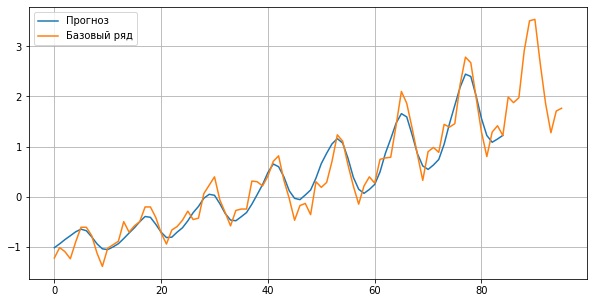

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_train, label='Прогноз')
plt.plot(y_train[:train_split].values, label='Базовый ряд')
plt.legend()
plt.show()

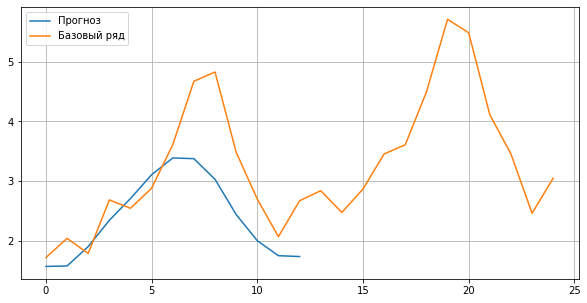

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_val[h:], label='Прогноз')
plt.plot(y_val[:].values, label='Базовый ряд')
plt.legend()
plt.show()

## Проверим вляяние параметра batch_size

In [ ]:
dataset_train, dataset_val, inputs, targets = model_preparation(learning_rate = 0.001, batch_size = 24, epochs = 50)
model = my_model()

Input shape: (24, 12, 3)
Target shape: (24,)


Epoch 1/50
4/4 [==============================] - 5s 292ms/step - loss: 0.5946 - mae: 0.6429 - val_loss: 5.6962 - val_mae: 2.1954
Epoch 2/50
4/4 [==============================] - 0s 38ms/step - loss: 0.2698 - mae: 0.3939 - val_loss: 3.2760 - val_mae: 1.5618
Epoch 3/50
4/4 [==============================] - 0s 47ms/step - loss: 0.1490 - mae: 0.2782 - val_loss: 1.5355 - val_mae: 0.9208
Epoch 4/50
4/4 [==============================] - 0s 40ms/step - loss: 0.1656 - mae: 0.3441 - val_loss: 0.8262 - val_mae: 0.6528
Epoch 5/50
4/4 [==============================] - 0s 46ms/step - loss: 0.1830 - mae: 0.3731 - val_loss: 0.7248 - val_mae: 0.6092
Epoch 6/50
4/4 [==============================] - 0s 40ms/step - loss: 0.1142 - mae: 0.2847 - val_loss: 0.9033 - val_mae: 0.6997
Epoch 7/50
4/4 [==============================] - 0s 41ms/step - loss: 0.0715 - mae: 0.2040 - val_loss: 1.1257 - val_mae: 0.8132
Epoch 8/50
4/4 [==============================] - 0s 45ms/step - loss: 0.0714 - mae: 0.2054 - va

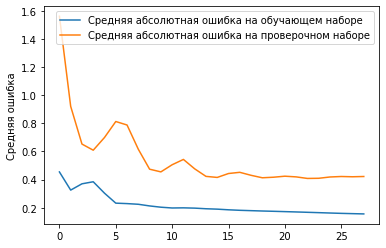

In [ ]:
history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
pred_train = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

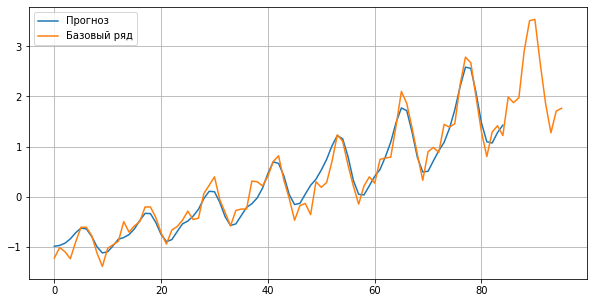

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_train, label='Прогноз')
plt.plot(y_train[:train_split].values, label='Базовый ряд')
plt.legend()
plt.show()

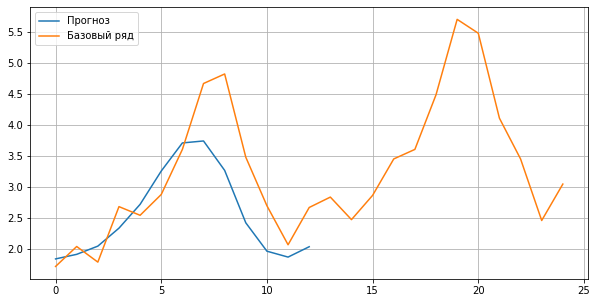

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_val[h:], label='Прогноз')
plt.plot(y_val[:].values, label='Базовый ряд')
plt.legend()
plt.show()

Уменьшим batch_size

In [ ]:
dataset_train, dataset_val, inputs, targets = model_preparation(learning_rate = 0.001, batch_size = 6, epochs = 50)
model = my_model()

Input shape: (6, 12, 3)
Target shape: (6,)


Epoch 1/50
15/15 [==============================] - 4s 69ms/step - loss: 0.5657 - mae: 0.6172 - val_loss: 2.8601 - val_mae: 1.4701
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 0.2536 - mae: 0.4461 - val_loss: 1.4474 - val_mae: 0.9219
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 0.1495 - mae: 0.3198 - val_loss: 1.1566 - val_mae: 0.8209
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0629 - mae: 0.1966 - val_loss: 0.9504 - val_mae: 0.7488
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0691 - mae: 0.2124 - val_loss: 0.8383 - val_mae: 0.6982
Epoch 6/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0652 - mae: 0.2038 - val_loss: 0.5976 - val_mae: 0.5704
Epoch 7/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0655 - mae: 0.2025 - val_loss: 0.6922 - val_mae: 0.6342
Epoch 8/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0649 - m

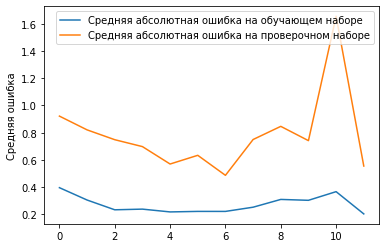

In [ ]:
history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
pred_train = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

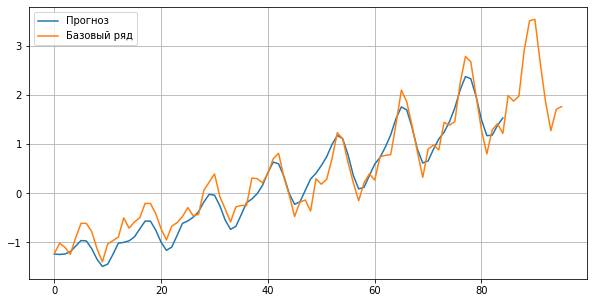

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_train, label='Прогноз')
plt.plot(y_train[:train_split].values, label='Базовый ряд')
plt.legend()
plt.show()

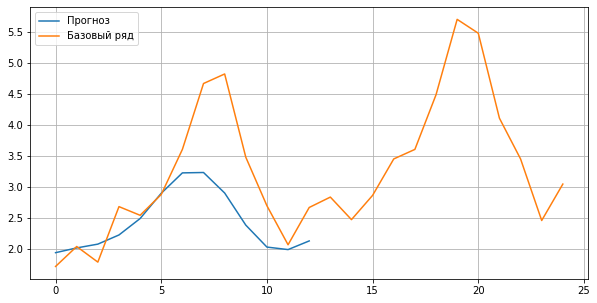

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_val[h:], label='Прогноз')
plt.plot(y_val[:].values, label='Базовый ряд')
plt.legend()
plt.show()

Видимо, уменьшение параметра приводит к ухудшению результата. Однако его увеличение не дает сильного преимущества в связи с тем, что такое увеличение существенно ограничено малым количеством самих наблюдений